In [90]:
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import csv

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def get_session():
    """Create a session that dynamically allocates memory."""
    # See: https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[ 1.00000203  1.00000274  0.99999923  0.99999964  1.00000107  1.00000036]


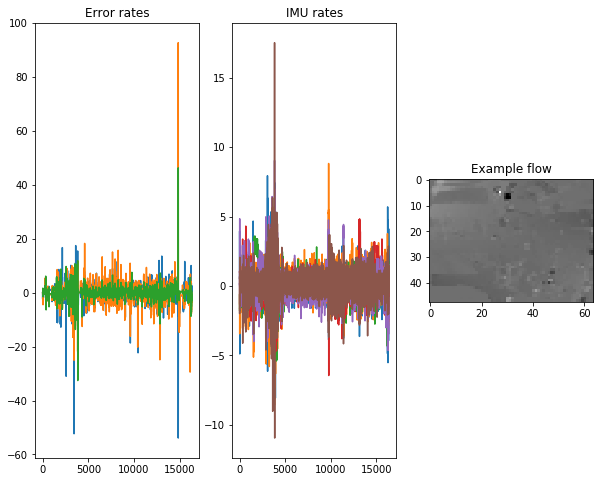

In [93]:
# Import data without time stamps
y_data = (np.genfromtxt('errors.csv', delimiter=',')[:,1:4]).astype(np.float32)
imu_data = (np.genfromtxt('rates.csv', delimiter=',')[:,1:7]).astype(np.float32)
# Normalize imu data:
imu_data = imu_data - imu_data.mean(axis=0)
imu_data /= np.std(imu_data,axis=0)
print(np.std(imu_data,axis=0))

#flows_data = np.load('/media/Big_Data/stefantj/flows1.npy') # note: this only loads 1k flows, the whole flow file is huge!
flows_data = np.load('/media/Big_Data/stefantj/flows_lowres.npy') # Currently has 2k images, downsampled to 64x48.
plt.subplot(1,3,1)
plt.title('Error rates')
plt.plot(y_data)
plt.subplot(1,3,2)
plt.title('IMU rates')
plt.plot(imu_data)
plt.subplot(1,3,3)
plt.title('Example flow')
plt.imshow(flows_data[np.random.randint(0,flows_data.shape[0]),:,:,1])

# sample batch_size subsequences of length sequence_length, and return the label at the end of the sequence
def sample_minibatch(sequence_length, batch_size, iseq=None):
    x_imu_batch = np.zeros((sequence_length, batch_size, imu_data.shape[1]))
    x_img_batch = np.zeros((sequence_length, batch_size, flows_data.shape[1], flows_data.shape[2], flows_data.shape[3]))
    y_batch = np.zeros((batch_size, y_data.shape[1]))
    
    for k in range(batch_size):
        if(iseq is None):
            # randomly sample endpoint:
            i_stop = np.random.randint(sequence_length, flows_data.shape[0]) 
        else:
            i_stop = iseq - (batch_size-1-k)
        x_imu_batch[:,k,:] = imu_data[i_stop-sequence_length:i_stop,:]
        y_batch[k,:] = y_data[sequence_length,:]
        x_img_batch[:,k,:,:,:] = flows_data[i_stop-sequence_length:i_stop,:,:,:]
    return x_imu_batch, x_img_batch, y_batch

def calc_rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [94]:
# Definition of network:
# rescale the images ~ 64x48
# Try normalizing 
# feed output back in
# see if you can get cats roughly hte same size

OUTPUT_DIM = 3
BATCH_SIZE = 3
R_HISTORY = 10
IMG_H = 48
IMG_W = 64
class tangoNet(object):

    # Extract features for a single time step
    def extract_features(self, input_img=None, input_imu=None, reuse=True):
        if input_img is None:
            input_img = self.image  # will need to split this into input1, input2
        if input_imu is None:
            input_imu = self.imu
        x = input_img
        x_r = input_imu
# Removing the lstm for imu directly - we have same rate imu and images.         
#        x_r = tf.unstack(input_imu, self.r1_depth, 1)

        layers = []
        with tf.variable_scope('features', reuse=reuse):
            with tf.variable_scope('cnn_1'):
                # 64 filters of size 5 <- needs to be tuned!
                x = tf.layers.conv2d(x, 16, 3, strides=2, activation=tf.nn.relu, padding='valid')
                layers.append(x)     
            with tf.variable_scope('cnn_2'):
                x = tf.nn.max_pool(x, [1,3,3,1],strides=[1,2,2,1],padding='VALID')
                layers.append(x)
# Removing the lstm for imu directly - we have same rate imu and images. 
#            with tf.variable_scope('rnn_0'):
#                lstm_cell = tf.contrib.rnn.BasicLSTMCell(10)
#                x_r, states = tf.contrib.rnn.static_rnn(lstm_cell, x_r, dtype=tf.float32)
#                layers.append(x_r[-1])
            with tf.variable_scope('dense_1'):
                x_r = tf.layers.dense(x_r, 32, activation=tf.nn.relu)
                layers.append(x_r)
            with tf.variable_scope('concat1'):
                # reshape: 
                x = tf.reshape(x, [BATCH_SIZE,-1])
                x_r = tf.reshape(x_r, [BATCH_SIZE,-1])
                x = tf.concat([x,x_r],1)
                layers.append(x)
            return layers

    def __init__(self, batch_size, save_path=None, sess=None):
        self.batch_size = tf.constant(batch_size,dtype=tf.int32)
        # r_depth, batch, width, height, channels
        self.image = tf.placeholder('float',shape=[R_HISTORY, batch_size,IMG_H,IMG_W,2],name='input_image_seq')
        # r_depth, batch, input_dim
        self.imu   = tf.placeholder('float',shape=[R_HISTORY, batch_size,6],name='input_imu_seq')
        # batch, output_dim
        self.errs  = tf.placeholder('float',shape=[batch_size, OUTPUT_DIM],name='output_error')

        self.layers0 = self.extract_features(self.image[0,:,:,:,:], self.imu[0,:,:], reuse=False)
        self.layers1 = self.extract_features(self.image[1,:,:,:,:], self.imu[1,:,:], reuse=True)
        self.layers2 = self.extract_features(self.image[2,:,:,:,:], self.imu[2,:,:], reuse=True)
        self.layers3 = self.extract_features(self.image[3,:,:,:,:], self.imu[3,:,:], reuse=True)
        self.layers4 = self.extract_features(self.image[4,:,:,:,:], self.imu[4,:,:], reuse=True)
        self.layers5 = self.extract_features(self.image[5,:,:,:,:], self.imu[5,:,:], reuse=True)
        self.layers6 = self.extract_features(self.image[6,:,:,:,:], self.imu[6,:,:], reuse=True)
        self.layers7 = self.extract_features(self.image[7,:,:,:,:], self.imu[7,:,:], reuse=True)
        self.layers8 = self.extract_features(self.image[8,:,:,:,:], self.imu[8,:,:], reuse=True)
        self.layers9 = self.extract_features(self.image[9,:,:,:,:], self.imu[9,:,:], reuse=True)
        self.features = [self.layers0[-1], self.layers1[-1], self.layers2[-1],\
                         self.layers3[-1], self.layers4[-1], self.layers5[-1],\
                         self.layers6[-1], self.layers7[-1], self.layers8[-1], self.layers9[-1]]
        
        with tf.variable_scope('core_lstm'):
            with tf.variable_scope('core_0'):
                x_r = self.features
                self.layers3.append(x_r)
            with tf.variable_scope('core_1'):
                lstm_cell = tf.contrib.rnn.BasicLSTMCell(128)
                x_r, states = tf.contrib.rnn.static_rnn(lstm_cell, x_r, dtype=tf.float32)
                self.layers3.append(x_r[-1])
            with tf.variable_scope('core_2'):
                W = tf.get_variable("weights", shape=[128,OUTPUT_DIM])
                b = tf.get_variable("bias", shape=[OUTPUT_DIM])
                x_r = tf.matmul(x_r[-1], W) + b
                self.layers3.append(x_r)
        self.prediction = tf.reshape(x_r, [-1, OUTPUT_DIM])


        if save_path is not None:
            saver = tf.train.Saver()
            saver.restore(sess, save_path)
        self.rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(self.errs, self.prediction)))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(self.rmse)


Step:  10  MSE:  0.355431  Val:  0.685977


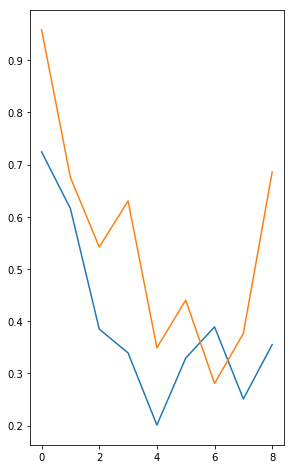

Step:  20  MSE:  0.371469  Val:  0.468843


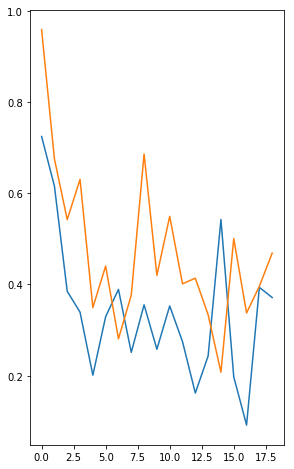

Step:  30  MSE:  0.27095  Val:  0.289532


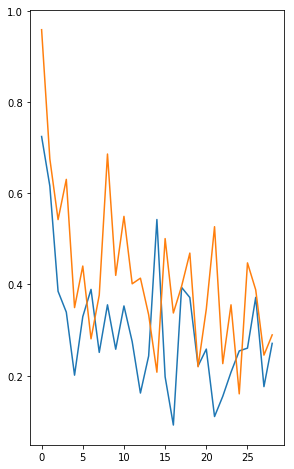

Step:  40  MSE:  0.150676  Val:  0.192926


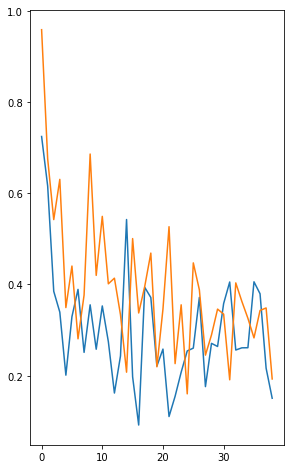

Step:  50  MSE:  0.249761  Val:  0.123844


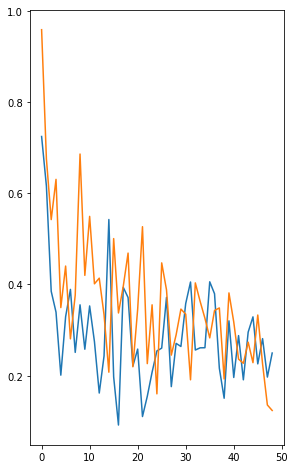

Step:  60  MSE:  0.168264  Val:  0.23885


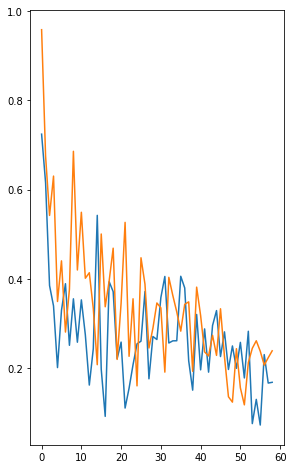

Step:  70  MSE:  0.210646  Val:  0.188452


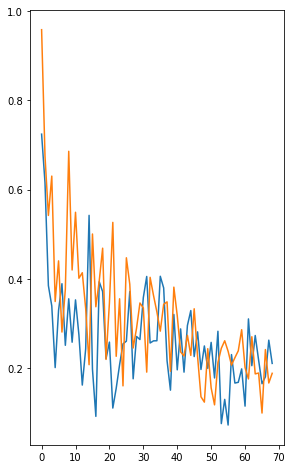

Step:  80  MSE:  0.121451  Val:  0.201933


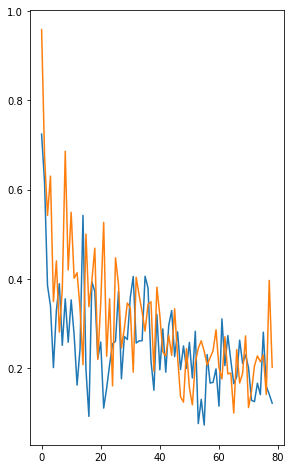

Step:  90  MSE:  0.200758  Val:  0.194381


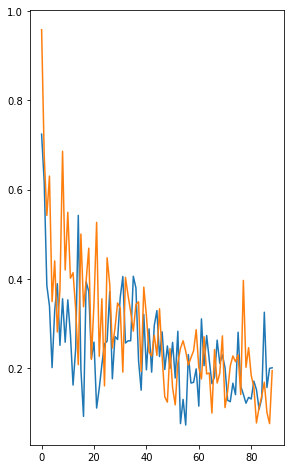

Step:  100  MSE:  0.140653  Val:  0.118456


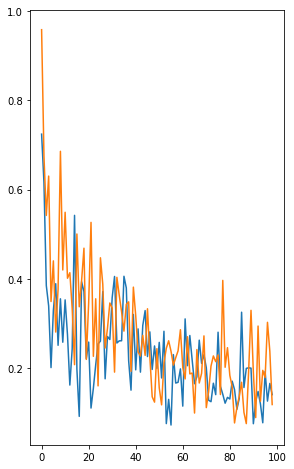

Step:  110  MSE:  0.125419  Val:  0.145437


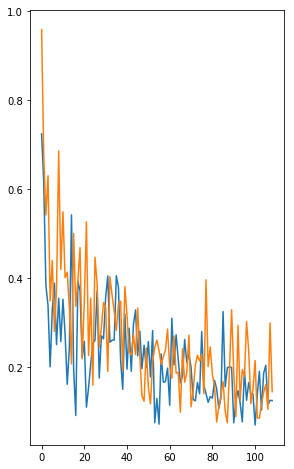

Step:  120  MSE:  0.0643949  Val:  0.215608


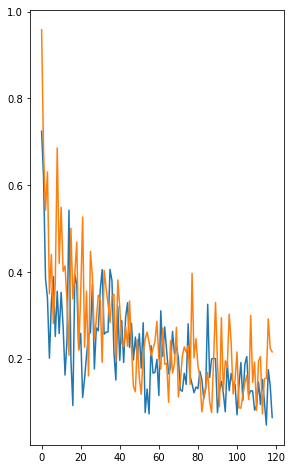

Step:  130  MSE:  0.110699  Val:  0.207166


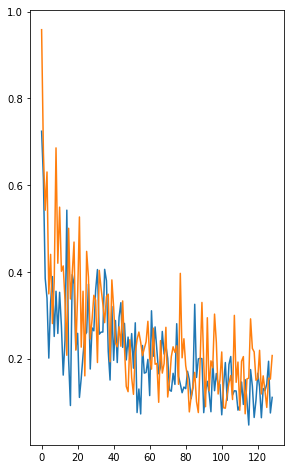

Step:  140  MSE:  0.0511856  Val:  0.138574


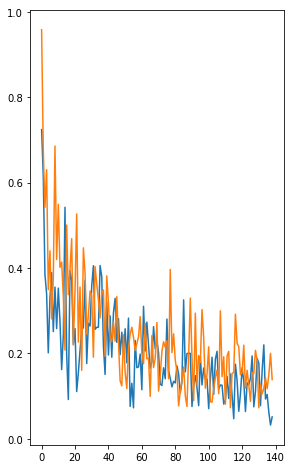

Step:  150  MSE:  0.0946844  Val:  0.129152


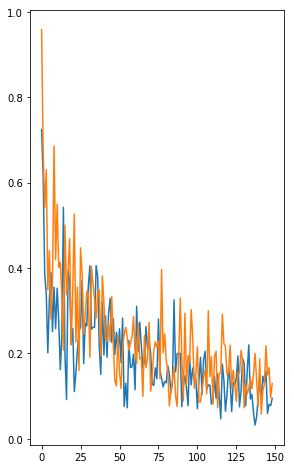

Step:  160  MSE:  0.165301  Val:  0.10512


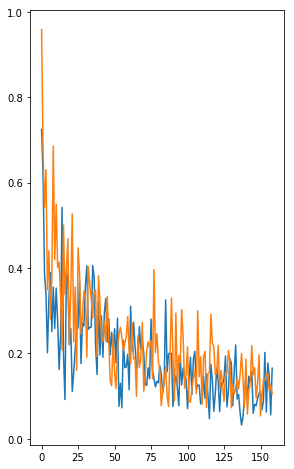

Step:  170  MSE:  0.0437989  Val:  0.231503


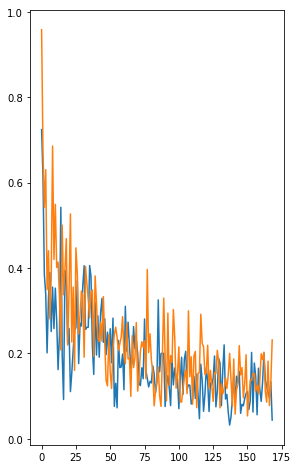

Step:  180  MSE:  0.0641837  Val:  0.111185


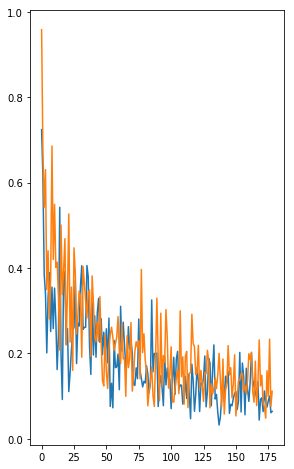

Step:  190  MSE:  0.238971  Val:  0.109779


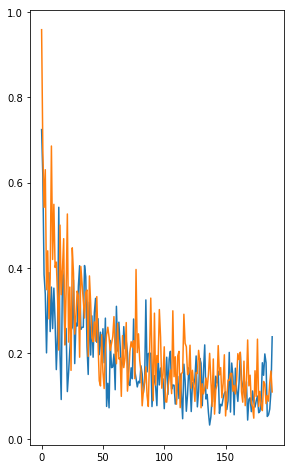

Step:  200  MSE:  0.0465876  Val:  0.0445698


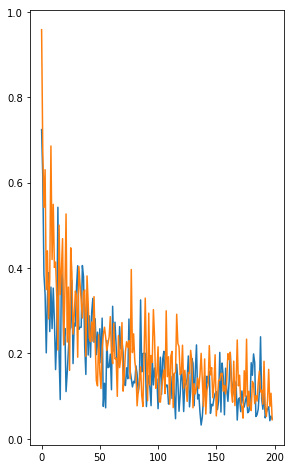

Step:  210  MSE:  0.120182  Val:  0.0300089


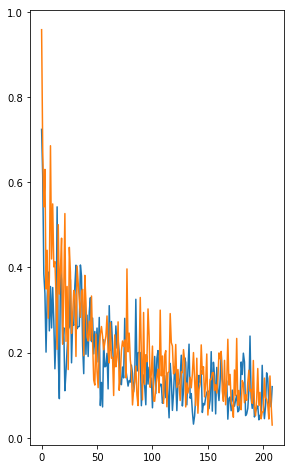

Step:  220  MSE:  0.0959204  Val:  0.0668867


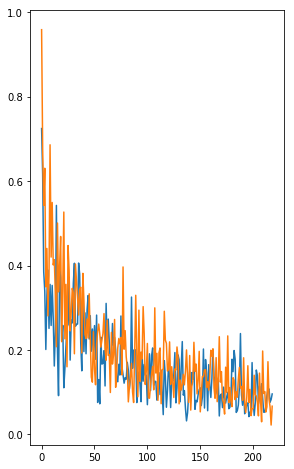

Step:  230  MSE:  0.0799927  Val:  0.0543251


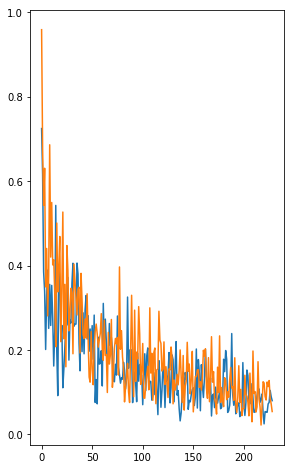

Step:  240  MSE:  0.125082  Val:  0.0331672


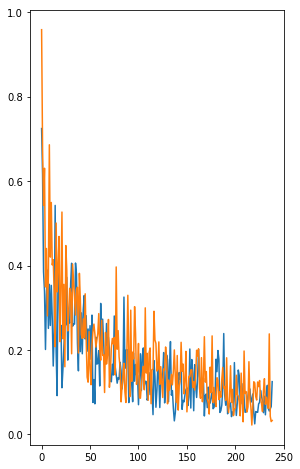

Step:  250  MSE:  0.0778698  Val:  0.0555403


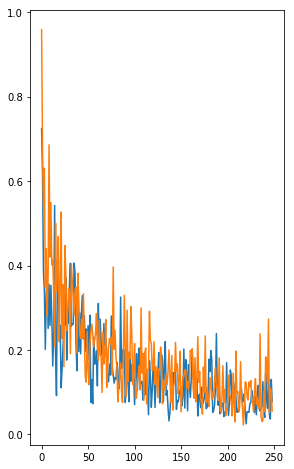

Step:  260  MSE:  0.0774821  Val:  0.0606337


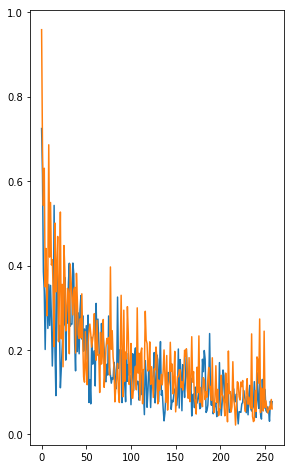

Step:  270  MSE:  0.0809359  Val:  0.0968178


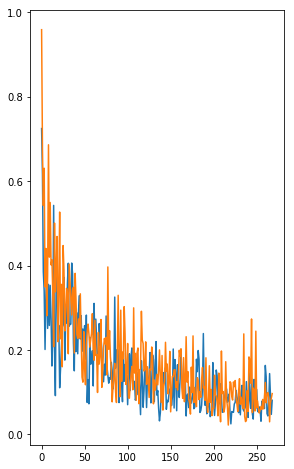

Step:  280  MSE:  0.0944869  Val:  0.141585


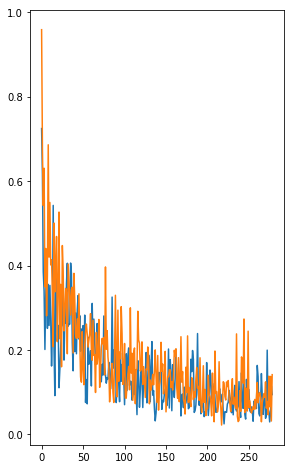

Step:  290  MSE:  0.032305  Val:  0.0347022


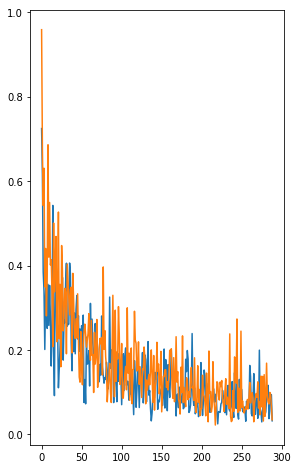

Step:  300  MSE:  0.0915332  Val:  0.0509638


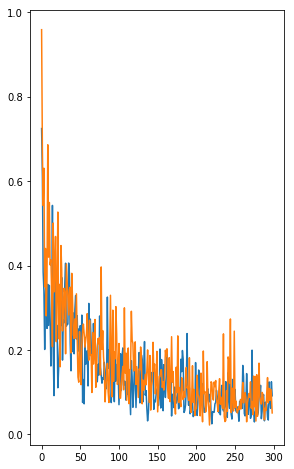

Step:  310  MSE:  0.0468551  Val:  0.110458


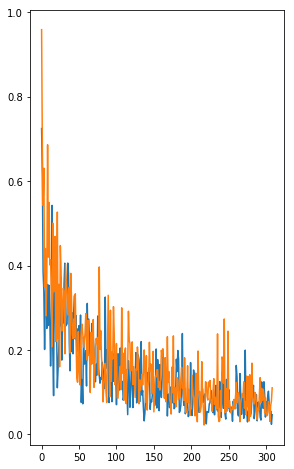

Step:  320  MSE:  0.0419416  Val:  0.0631865


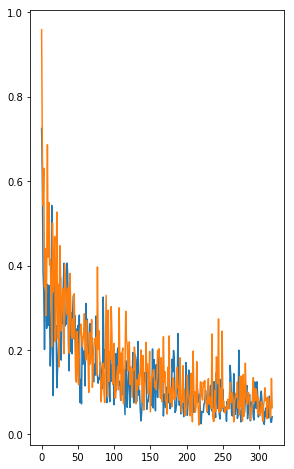

Step:  330  MSE:  0.173267  Val:  0.0524676


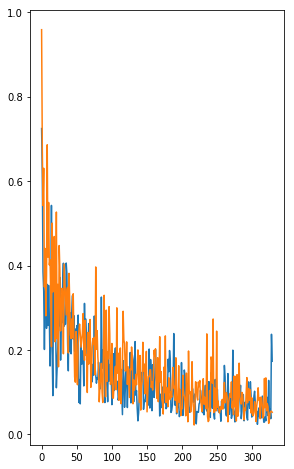

Step:  340  MSE:  0.047006  Val:  0.111656


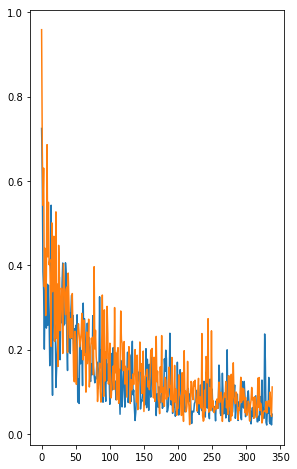

Step:  350  MSE:  0.0582808  Val:  0.0634228


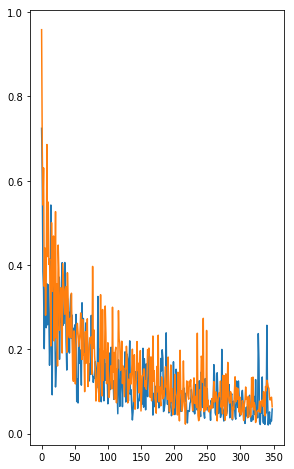

Step:  360  MSE:  0.0675361  Val:  0.0760669


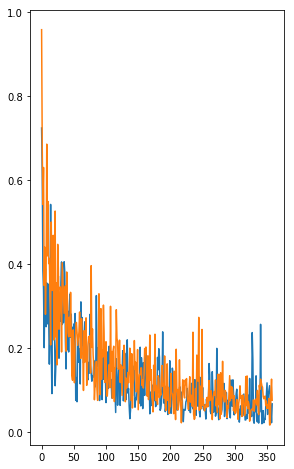

Step:  370  MSE:  0.0585912  Val:  0.0415468


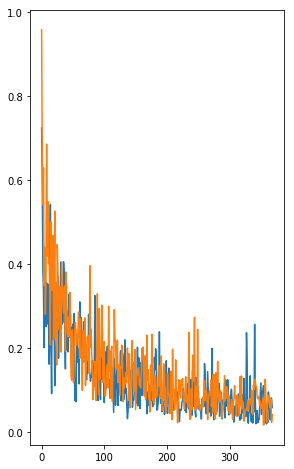

Step:  380  MSE:  0.0911127  Val:  0.078402


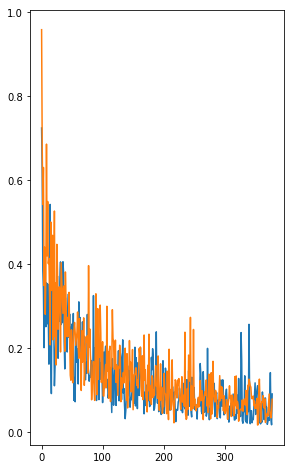

Step:  390  MSE:  0.0221225  Val:  0.0634026


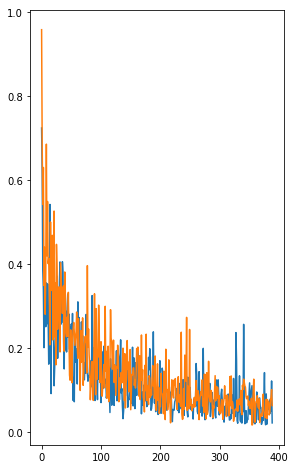

Step:  400  MSE:  0.0131959  Val:  0.122801


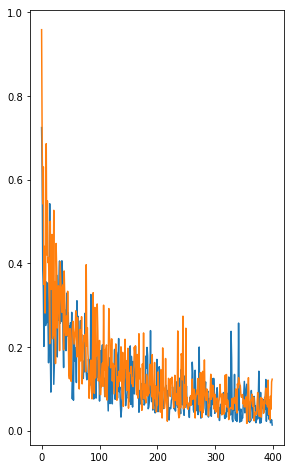

Step:  410  MSE:  0.0505096  Val:  0.0587975


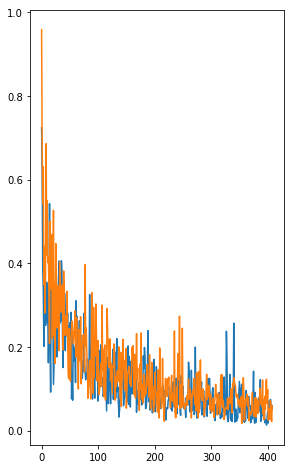

Step:  420  MSE:  0.0445685  Val:  0.0418423


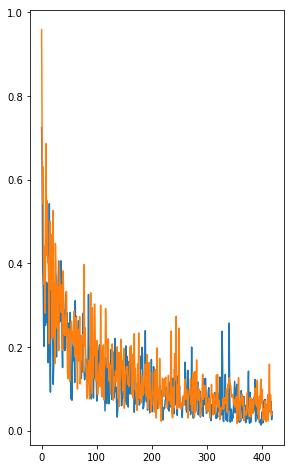

Step:  430  MSE:  0.0259967  Val:  0.0235499


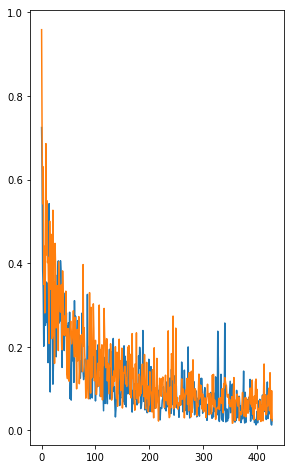

Step:  440  MSE:  0.048086  Val:  0.0490531


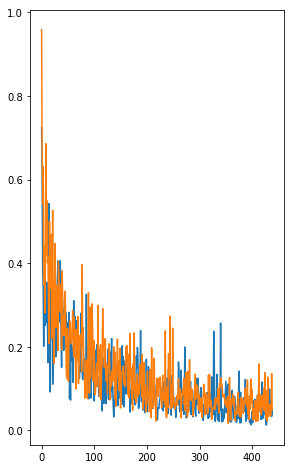

Step:  450  MSE:  0.0327833  Val:  0.0540657


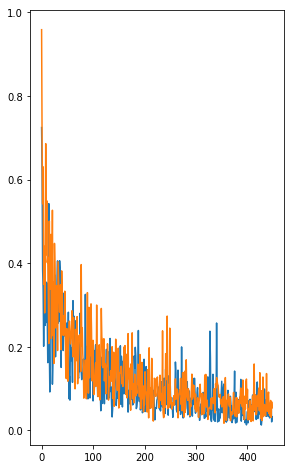

Step:  460  MSE:  0.0680814  Val:  0.0412368


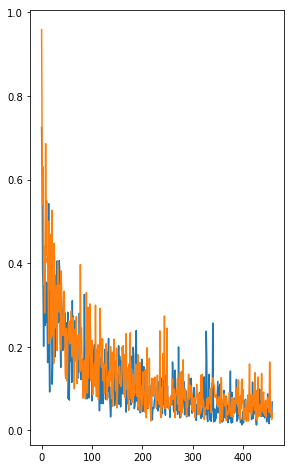

Step:  470  MSE:  0.0443483  Val:  0.0291563


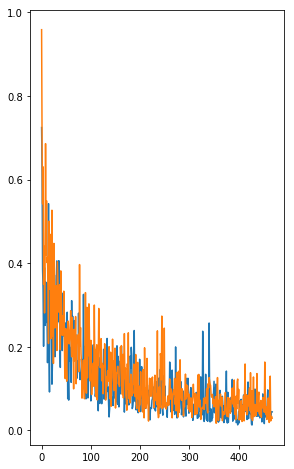

Step:  480  MSE:  0.0360932  Val:  0.0362424


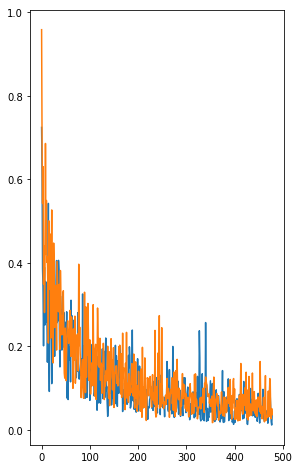

Step:  490  MSE:  0.0252944  Val:  0.0244284


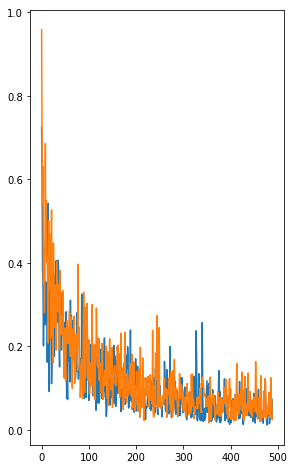

Step:  500  MSE:  0.0311367  Val:  0.0712625


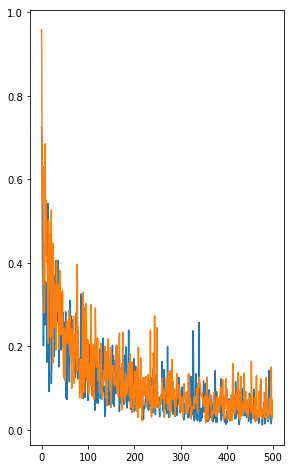

Step:  510  MSE:  0.0594335  Val:  0.059823


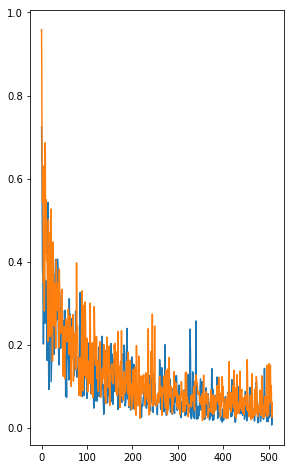

Step:  520  MSE:  0.0171819  Val:  0.0348932


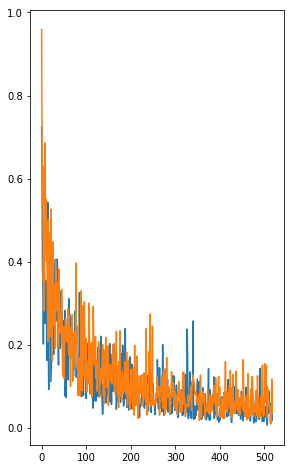

Step:  530  MSE:  0.0889677  Val:  0.0385305


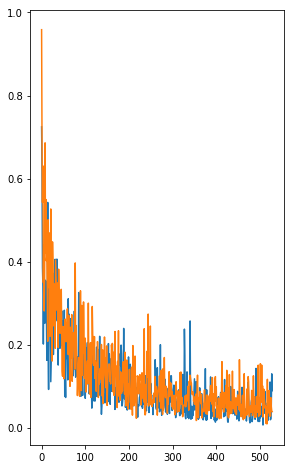

Step:  540  MSE:  0.0181023  Val:  0.050635


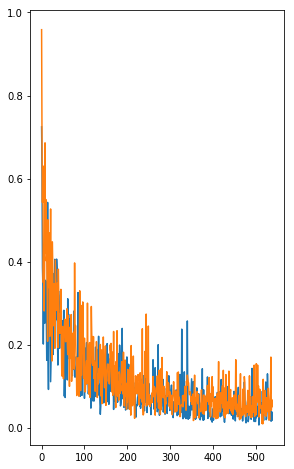

Step:  550  MSE:  0.0341236  Val:  0.0780762


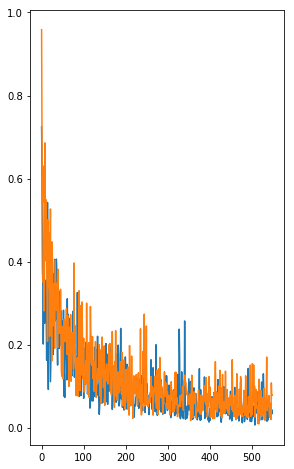

Step:  560  MSE:  0.0392545  Val:  0.0165116


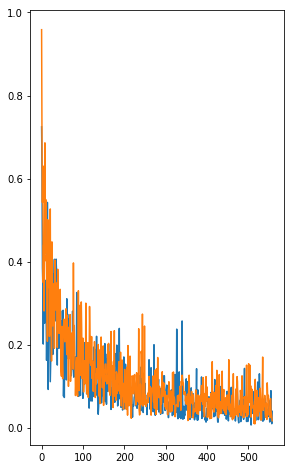

Step:  570  MSE:  0.0247212  Val:  0.0441794


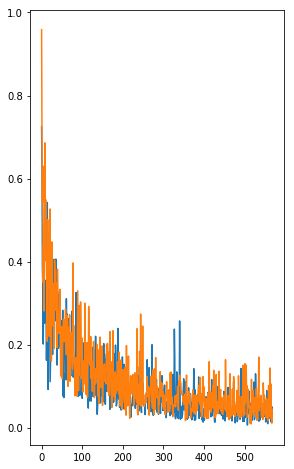

Step:  580  MSE:  0.0161209  Val:  0.0505052


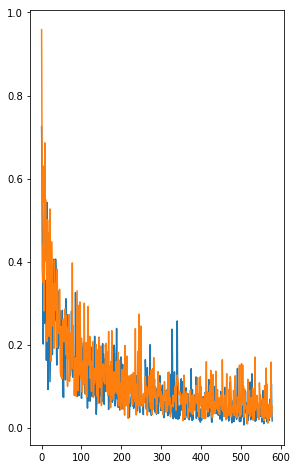

Step:  590  MSE:  0.171164  Val:  0.0495944


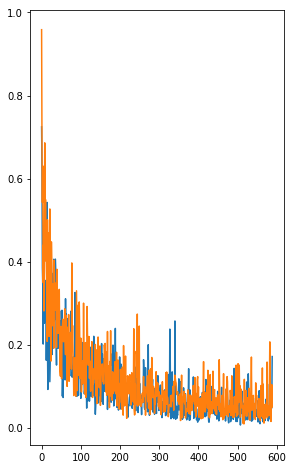

Step:  600  MSE:  0.0226583  Val:  0.0388337


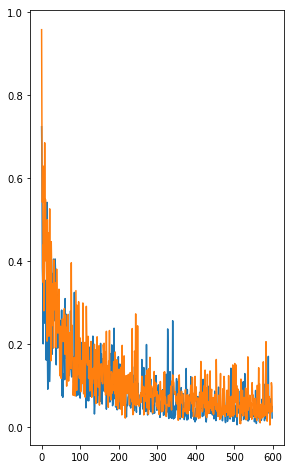

Step:  610  MSE:  0.046795  Val:  0.00773212


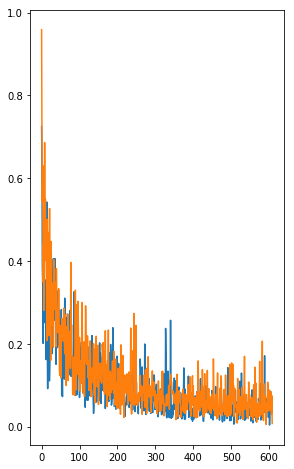

Step:  620  MSE:  0.0744065  Val:  0.0465291


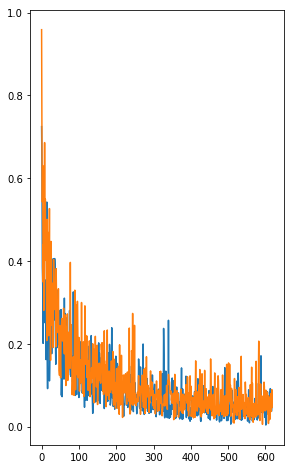

Step:  630  MSE:  0.0278241  Val:  0.046998


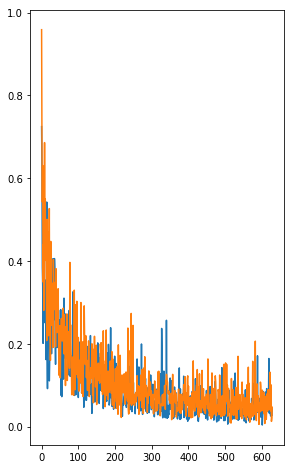

Step:  640  MSE:  0.0318745  Val:  0.0624336


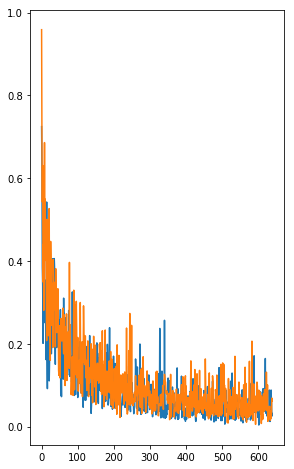

Step:  650  MSE:  0.0131138  Val:  0.0932597


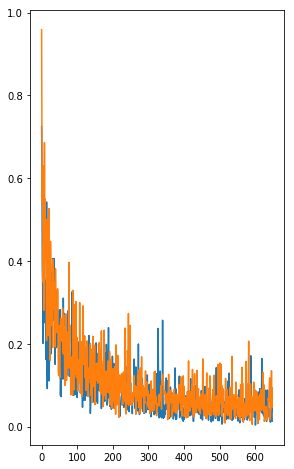

Step:  660  MSE:  0.0262138  Val:  0.13504


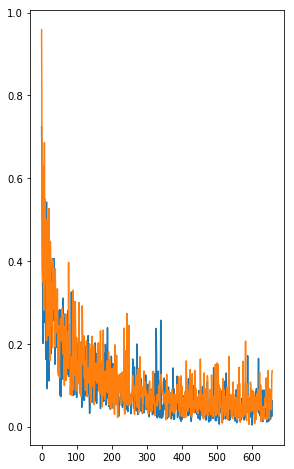

Step:  670  MSE:  0.0299436  Val:  0.038862


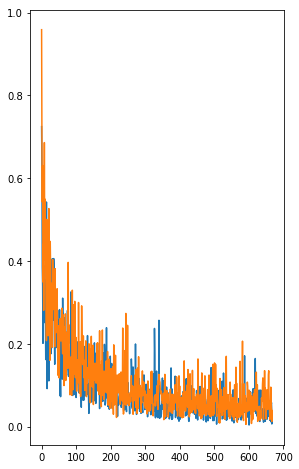

Step:  680  MSE:  0.0731246  Val:  0.0486101


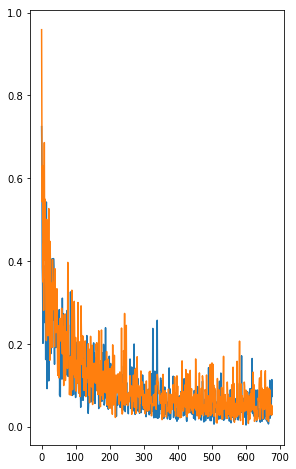

Step:  690  MSE:  0.0490096  Val:  0.0267271


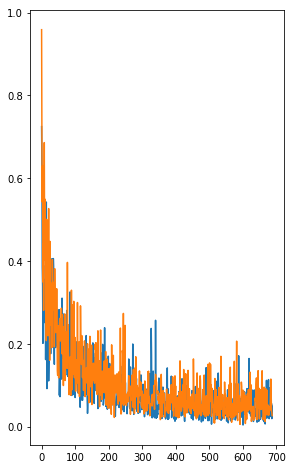

Step:  700  MSE:  0.031811  Val:  0.0912377


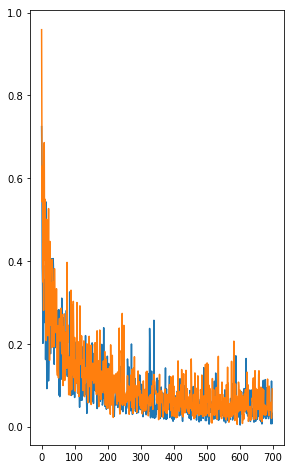

Step:  710  MSE:  0.0234814  Val:  0.0281096


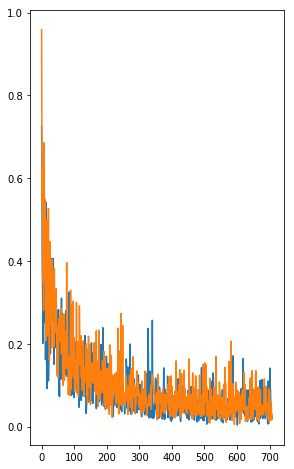

Step:  720  MSE:  0.0211604  Val:  0.0436319


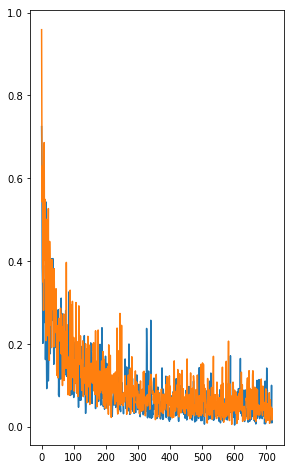

Step:  730  MSE:  0.0445097  Val:  0.0426065


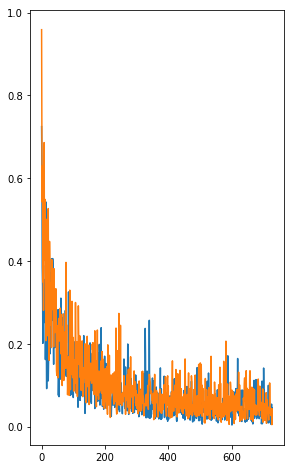

Step:  740  MSE:  0.0596824  Val:  0.0233729


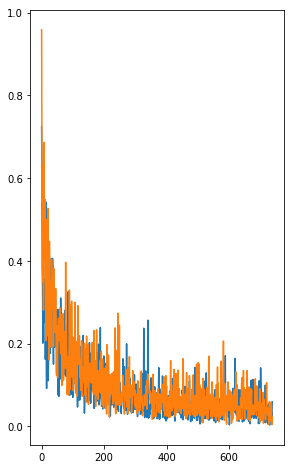

Step:  750  MSE:  0.0263473  Val:  0.0516365


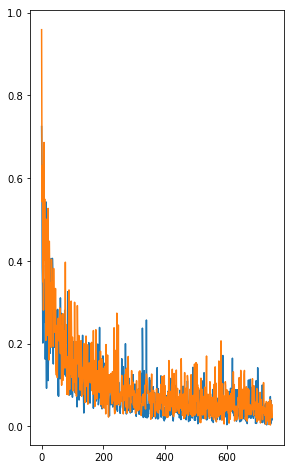

Step:  760  MSE:  0.0355487  Val:  0.0863288


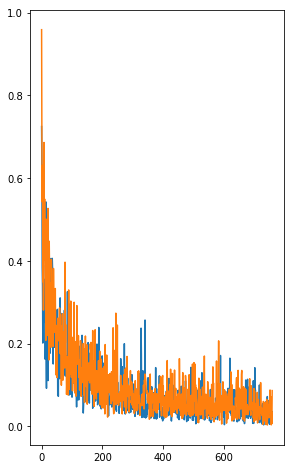

Step:  770  MSE:  0.0524492  Val:  0.0855694


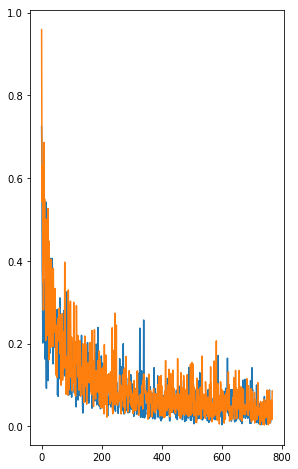

Step:  780  MSE:  0.0232039  Val:  0.0386626


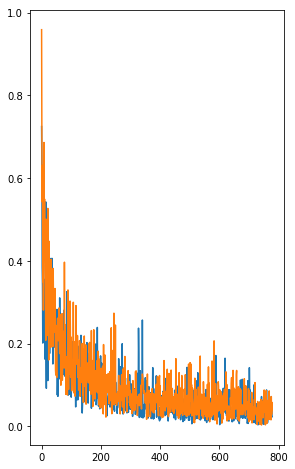

Step:  790  MSE:  0.0303571  Val:  0.0263346


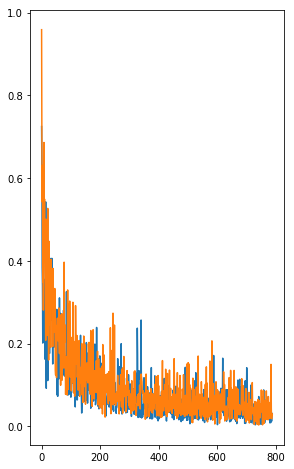

Step:  800  MSE:  0.00735188  Val:  0.0148783


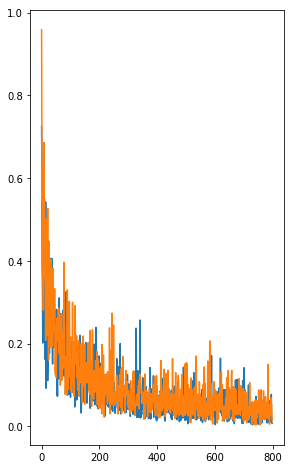

Step:  810  MSE:  0.0514768  Val:  0.0334226


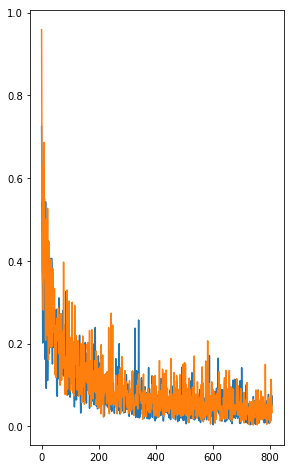

Step:  820  MSE:  0.0122502  Val:  0.114352


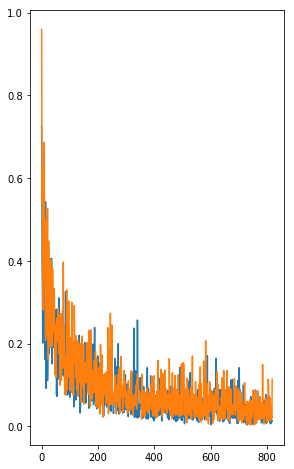

Step:  830  MSE:  0.0332006  Val:  0.0396095


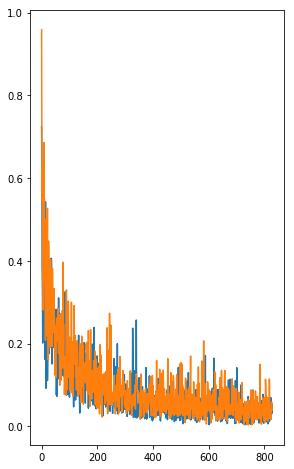

Step:  840  MSE:  0.105107  Val:  0.0545596


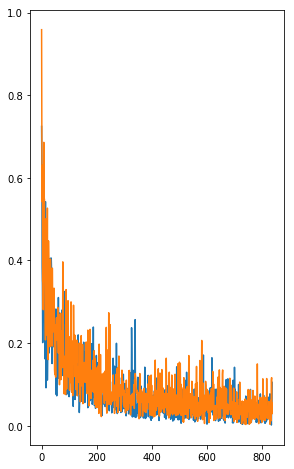

Step:  850  MSE:  0.0135336  Val:  0.00790843


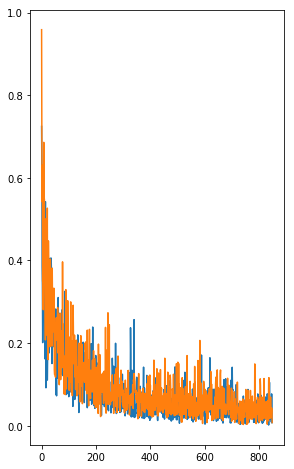

Step:  860  MSE:  0.0510532  Val:  0.054397


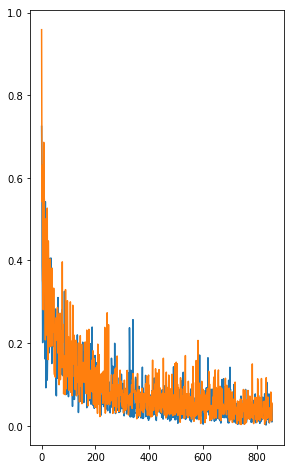

Step:  870  MSE:  0.0166477  Val:  0.0657053


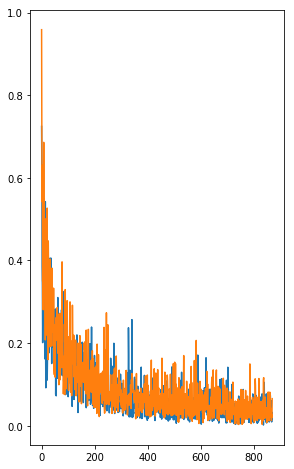

Step:  880  MSE:  0.0182073  Val:  0.0169863


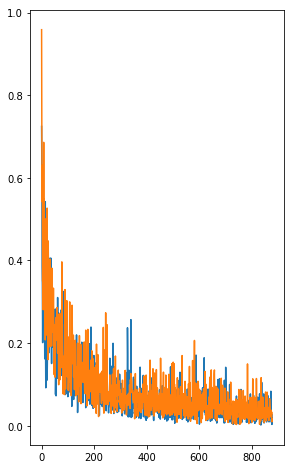

Step:  890  MSE:  0.0624185  Val:  0.0102258


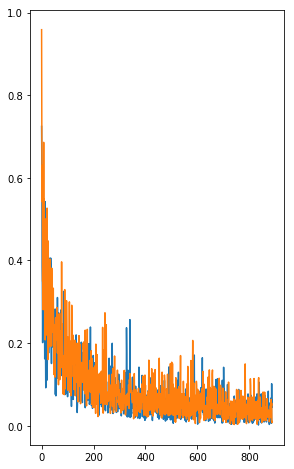

Step:  900  MSE:  0.0915861  Val:  0.0186466


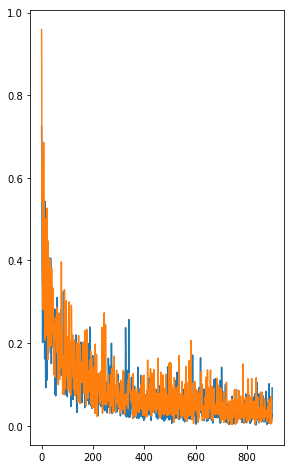

Step:  910  MSE:  0.0359463  Val:  0.0110654


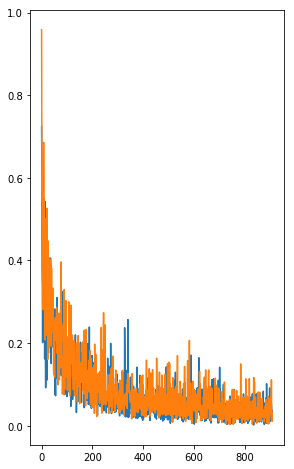

Step:  920  MSE:  0.0240616  Val:  0.0528037


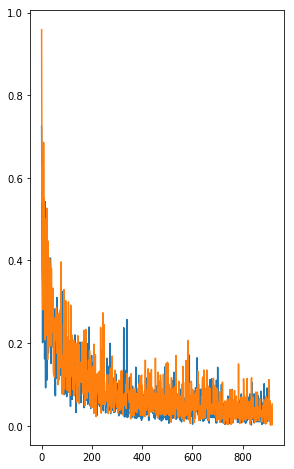

Step:  930  MSE:  0.0181345  Val:  0.062324


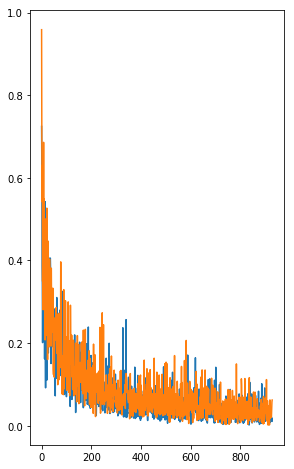

Step:  940  MSE:  0.0282781  Val:  0.0666191


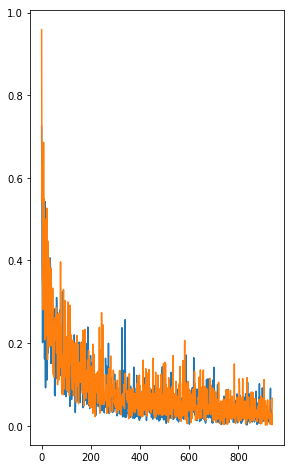

Step:  950  MSE:  0.0276931  Val:  0.0502043


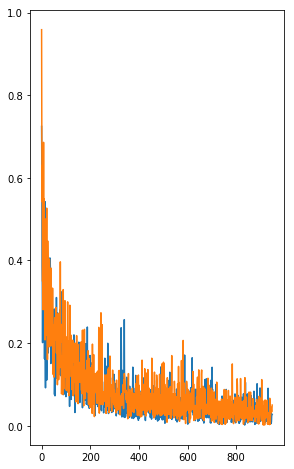

Step:  960  MSE:  0.0329637  Val:  0.00799569


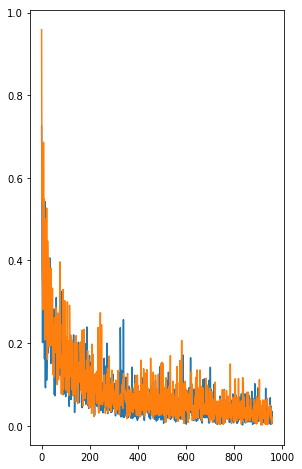

Step:  970  MSE:  0.0144611  Val:  0.0299928


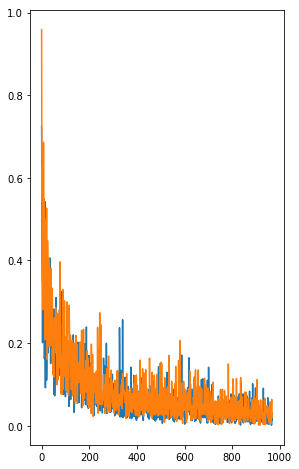

Step:  980  MSE:  0.0236745  Val:  0.0189072


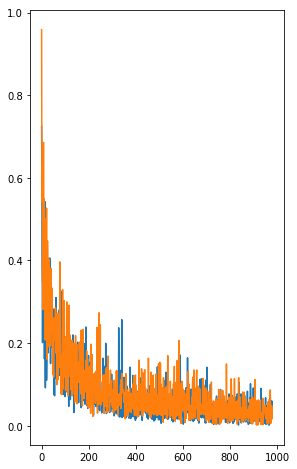

Step:  990  MSE:  0.014093  Val:  0.0221214


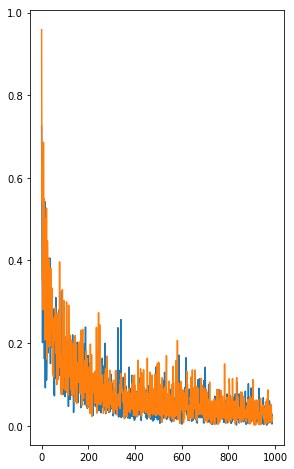

Step:  1000  MSE:  0.0173004  Val:  0.0164396


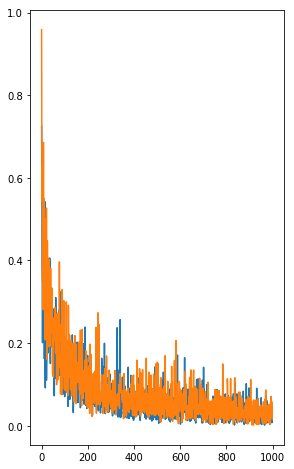

Computing sequence prediction - this may take a while. 
k =  100
k =  200
k =  300
k =  400
k =  500
k =  600
k =  700
k =  800
k =  900
k =  1000
k =  1100
k =  1200
k =  1300
k =  1400
k =  1500
k =  1600
k =  1700
k =  1800
k =  1900


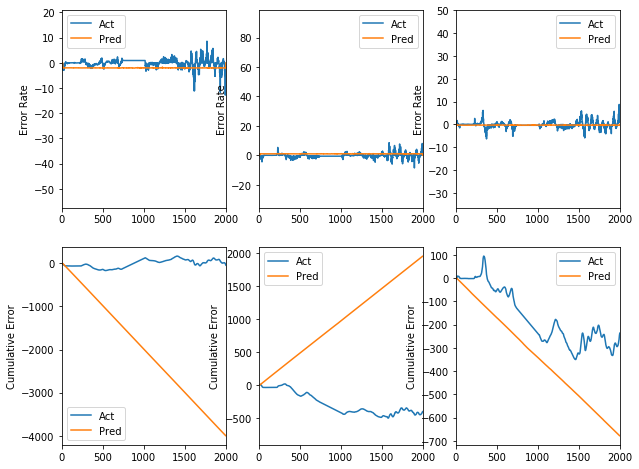

In [96]:
# simple parameters:
disp_period = 10
training_iters = 1000

with tf.device('/cpu:0'):
    tf.reset_default_graph()
    sess = get_session()
    SAVE_PATH = '/media/Big_Data/stefantj/tangonet.ckpt'

    model = tangoNet(batch_size = BATCH_SIZE, sess=sess)

        # Initializing the variables
    init = tf.global_variables_initializer()

    train_history = []
    val_history = []

    # Launch the graph
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step  < training_iters:
        # these batches are of size 1?
        # for now, just grab a random sequence of data:
        batch_x1, batch_x2, batch_y = sample_minibatch(R_HISTORY, BATCH_SIZE)

        # Run optimization op (backprop)
        sess.run(model.optimizer, feed_dict={model.imu: batch_x1, model.image: batch_x2, model.errs: batch_y})
        # Calculate batch accuracy
        mse = sess.run(model.rmse, feed_dict={model.imu: batch_x1, model.image: batch_x2, model.errs: batch_y})
        train_history.append(mse)
        # Calculate val accuracy:
        batch_x1, batch_x2, batch_y = sample_minibatch(R_HISTORY, BATCH_SIZE)
        vmse = sess.run(model.rmse, feed_dict={model.imu: batch_x1, model.image: batch_x2, model.errs: batch_y})
        val_history.append(vmse)
        step += 1
        if step % disp_period is 0:
            print('Step: ', step, ' MSE: ', mse, ' Val: ', vmse)
            plt.subplot(1,2,1)
            plt.plot(train_history)
            plt.plot(val_history)
            plt.show()
    # Compute sequence prediction:
    print('Computing sequence prediction - this may take a while. ')
    y_pred = np.zeros_like(y_data)
    for k in range(BATCH_SIZE+R_HISTORY, flows_data.shape[0]):
        if k % 100 is 0:
            print('k = ', k)
        batch_x1, batch_x2, batch_y = sample_minibatch(R_HISTORY, BATCH_SIZE, k)
        pred = sess.run(model.prediction, feed_dict={model.imu: batch_x1, model.image: batch_x2, model.errs: batch_y})
        y_pred[k,:] = pred[-1,:]

    for k in range(3):
        plt.subplot(2,3,k+1)
        plt.ylabel('Error Rate')
        plt.plot(y_data[:,k])
        plt.plot(y_pred[:,k])
        plt.legend(['Act','Pred'])
        plt.xlim([0,flows_data.shape[0]])
                
        plt.subplot(2,3,k+4)
        plt.ylabel('Cumulative Error')
        plt.plot(np.cumsum(y_data[:,k]))
        plt.plot(np.cumsum(y_pred[:,k]))
        plt.legend(['Act','Pred'])
        plt.xlim([0,flows_data.shape[0]])

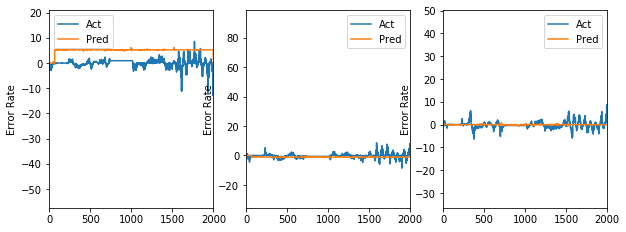

In [73]:
    for k in range(3):
        plt.subplot(2,3,k+1)
        plt.ylabel('Error Rate')
        plt.plot(y_data[:,k])
        plt.plot(y_pred[:,k])
        plt.legend(['Act','Pred'])
        plt.xlim([0,flows_data.shape[0]])
                
